# PALS0039 Introduction to Deep Learning for Speech and Language Processing  

###**Asessment Coursework: Autocompletion Task**

####Student ID: NVMH6

####Word Count:

___
#Task Overview

Humans possess a remarkable ability to complete words, sentences, and even sounds, even when parts are missing or obscured. Autocompletion systems, as exemplified by text-editing software, emulate this capability by providing text suggestions, enhancing efficiency in text-based communication. This coursework focuses on building such an autocompletion system, specifically by implementing a next-character prediction model. This approach predicts subsequent characters given a preceding character sequence, operating regardless of word boundaries. While the model's primary function is next-character prediction, its ability to generate coherent text will be demonstrated by prompting it to generate short story-like sequences, leveraging the fact that the model is trained on fiction stories.

In developing this system, I considered both word-level and character-level input representations. However, a **character-level approach** was chosen due to its ability to handle out-of-vocabulary (OOV) words and its smaller vocabulary size, which allows for more extensive use of training data. Although word-level representations offer the advantage of shorter sequences and the potential to capture more semantic meaning, the character-level approach is more suitable for this task.

For this task, I chose to use a **Long Short-Term Memory** (LSTM) network, a type of recurrent neural network (RNN) that excels at sequence modeling. LSTMs are designed to capture long-range dependencies within sequential data, a crucial requirement for autocompletion. Unlike standard RNNs, LSTMs incorporate mechanisms to address the vanishing and exploding gradient problems, enabling them to learn from longer sequences. More information on the aspects of the architecture can be found in the Model Implementation section.

___
#Data Wrangling & Environment Set up

The data pre-processing section is split into the following code blocks:

1. Load relevant libraries and functions
2. Create a function to load the text files from the urls available on Moodle (accessed via the Project Gutenberg website)
3. Create a TextCharacterDataset class with the parent Dataset class from Pytorch
4. Splitting and inspecting the data


In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import requests
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import re
import torch

___
## Loading the URLs

This **load_text_from_url** function ensures that the text content from the Project Gutenberg URLs is retrieved properly. The requests library is a user-friendly way of handling communication with web servers and in this case, retrieving text content from the URLs.

After that,

I have decided to keep these functions separate from the Dataset class to prevent the Dataset class from becoming overloaded with additional functionality.



In [2]:
# Define function that will load the text file from the provided url
def load_text_from_url(url):
    """
    Loads text content from a given URL.

    Args:
        url: The URL of the text file.

    Returns:
        The text content as a string, or None if the download fails.
    """
    try:
        response = requests.get(url) # Send HTTP GET request to URLs provided
        response.raise_for_status()  # Raise an exception for bad status codes
        return response.text
    # If the execution was not succesful
    # The code below will be executed and an error message will be displayed
    except requests.exceptions.RequestException as e:
        print(f"Error downloading text from {url}: {e}")
        return None

___
## Defining the **TextCharacterDataset** class

I have implemented a Dataset class from Pytorch to ensure efficient and organised preprocessing of training/testing data.

To prepare the data, the text files are transformed into contexts and tokens. A **"context"** is the input of sequence characters that will be used to predict the subsequent three characters, and **"tokens"** are the numberical representations (indices) of these characters.

A crucial design choice for accelerating model training is the use of a fixed-size context window. To achieve this, each example will be truncated to a set length. If a context is shorter than this length, a special **\<PAD>** token will be added to the beginning of the context (left side padding). This is crucial to ensure that all input sequences have the same length, which is required for compatibility with an LSTM model.

This preprocessing allows for the simultaneous construction of the char2index dictionary and the characters list. The **char2index** dictionaty maps each unique character to a numberical index, and the **characters** list stores the entire corpus as a sequence of character indices. These data structures are essential for the model to be able to process the text data in a numerical format.


In [3]:
class TextCharacterDataset(Dataset):
    def __init__(self, text_urls, context_size):
      """
      The constructor of the TextCharacterDataset class
      Called when a new instance of the class is created

      Args:
          text_urls: a list of URLs
          context_size: integer to represent context window size
      """
      self.text_urls = text_urls
      self.context_size = context_size
      self.char2index = {"<PAD>": 0}  # Initialise char2index with padding
      self.characters = [] # Initialise characters list
      self.intro_regex = re.compile(r"CHAPTER I|BOOK I|Letter 1|CHAPTER 1")
      self.end_regex = re.compile(r"THE END|\*\*\* END OF THE PROJECT GUTENBERG EBOOK ")
      self.load_and_preprocess_data()  # Combine load and preprocess

    # Loads and processes text from the specified URLs.
    def load_and_preprocess_data(self):
      # Variable used to asign unique indices to characters
      next_index = 1
      all_text = ""

      for url in self.text_urls:
        text = self.load_text_from_url(url) # Get text from URL
        if text: # Only process if text was loaded successfully
          text = self.remove_gutenberg_intro(text)
          text = self.remove_gutenberg_end(text)
          text = self.clean_text(text)
          all_text += text

          # Create char2index from the cleaned text
          for char in all_text:
            if char not in self.char2index:
                # Extend the characters list
                self.char2index[char] = next_index
                next_index += 1

        # create self.characters using new char2index.
        self.characters = [self.char2index[char] for char in all_text]

    def load_text_from_url(self, url):
      try:
        response = requests.get(url)
        response.raise_for_status()  # Raise HTTPError for bad responses (4xx or 5xx)
        return response.text
      except requests.exceptions.RequestException as e:
        print(f"Error downloading {url}: {e}")
        return None

    def remove_gutenberg_intro(self, text):
      start_marker = "The Project Gutenberg eBook of "
      start_index = text.find(start_marker)
      end_match = self.intro_regex.search(text)

      if start_index != -1 and end_match:
        end_index = end_match.start()
        return text[end_index:]
      else:
        return text

    def remove_gutenberg_end(self, text):
        end_match = self.end_regex.search(text)

        if end_match:
            end_index = end_match.start()
            return text[:end_index + len(end_match.group(0))]
        else:
            return text

    def clean_text(self, text):
      text = text.lower()
      text = ''.join(c for c in text if c.isalnum() or c.isspace())
      return text

    # Defines length of dataset
    # Used by PyTorch's DataLoader
    def __len__(self):
      return len(self.characters) - self.context_size - 3 + 1

    def __getitem__(self, index):
      """
      Allows access to individual data points from dataset

      Args:
          index: position of data point to retrieve
      """
      start_idx = max(0, index)
      end_idx = start_idx + self.context_size
      context = self.characters[start_idx:end_idx]

      target_start_idx = end_idx
      target_end_idx = min(end_idx + 3, len(self.characters)) # Clamp target_end_idx
      targets = self.characters[target_start_idx:target_end_idx]

      # Handle cases where target is out of bounds
      if len(targets) == 0:
        return None

      # Pad context if necessary
      if len(context) < self.context_size:
          context = [self.char2index["<PAD>"]] * (self.context_size - len(context)) + context

      # Pad targets if necessary
      if len(targets) < 3:
          targets = targets + [self.char2index["<PAD>"]] * (3 - len(targets))

      input_ids = torch.LongTensor(context)
      target_ids = torch.LongTensor(targets)

      return input_ids, target_ids

___
##Data Splitting and Inspection

To ensure the model is able to generalise what it has learned, it was important to consider the size of the datasplit to allow the LSTM to have enough depth within the data, but also to not overpower the test and validation sets.

Source: https://www.v7labs.com/blog/train-validation-test-set

**Limitations:** While this approach is great for my fixed 7-book split, it does not allow me to experiment with different split ratios or combinations of books, as I would  would need to modify the train_urls, val_urls, and test_urls lists directly. Furthermore, if I was working with a much larger number of books or a more dynamic set of data sources, I would need to think of another way to

In [4]:
urls = [
    "https://www.gutenberg.org/cache/epub/345/pg345.txt",
    "https://www.gutenberg.org/cache/epub/2701/pg2701.txt",
    "https://www.gutenberg.org/cache/epub/1342/pg1342.txt",
    "https://www.gutenberg.org/cache/epub/84/pg84.txt",
    "https://www.gutenberg.org/cache/epub/3207/pg3207.txt",
    "https://www.gutenberg.org/cache/epub/1727/pg1727.txt",
    "https://www.gutenberg.org/cache/epub/74/pg74.txt",
]

# Split URLs into train, validation, and test sets
train_urls, temp_urls = train_test_split(urls, test_size=0.2, random_state=42)
val_urls, test_urls = train_test_split(temp_urls, test_size=0.5, random_state=42)

# Define context size
context_size = 100

# Create separate datasets for each split
train_data = TextCharacterDataset(train_urls, context_size)
val_data = TextCharacterDataset(val_urls, context_size)
test_data = TextCharacterDataset(test_urls, context_size)

# Inspect train, test & val dataset length
print(f"Train dataset size: {len(train_data)}")
print(f"Validation dataset size: {len(val_data)}")
print(f"Test dataset size: {len(test_data)}")

# Inspect shape of input and target tensor
print(f"Shape of input tensor: {train_data[0][0].shape}")
print(f"Shape of target tensor: {train_data[0][1].shape}")

Train dataset size: 2228732
Validation dataset size: 825711
Test dataset size: 1194688
Shape of input tensor: torch.Size([100])
Shape of target tensor: torch.Size([3])


___
# Model Implementation

I have selected an LSTM model from the RNN family because it is a model that is capable of capturing context and long-term dependencies. I believe that this will be highly beneficial to the autocompletion task.

This section is broken down into the following code blocks:
1. Defining the LSTM network class
2. Training the model
3. Model evaluation
3. Creating a user-friendly interface for the model

In [5]:
class CharLSTMModel(nn.Module):
    def __init__(self, n_characters, embedding_dimension, hidden_dimension):
        super().__init__()

        self.hidden_dimension = hidden_dimension

        # Embedding layer:
        # Converts character indices into dense vectors.
        # embedding_dimension determines the size of each vector.
        self.embedding_layer = nn.Embedding(n_characters, embedding_dimension)

        # LSTM layer:
        # Processes the embedded character sequences.
        # hidden_dimension determines the size of the hidden state,
        # which captures the LSTM's memory.
        self.LSTM = nn.LSTM(embedding_dimension, hidden_dimension, num_layers=1, batch_first=True)

        # Output layer:
        # Maps the LSTM's output to the probabilities of the next 3 characters.
        # 3 * n_characters because we are predicting 3 characters.
        self.output_layer = nn.Linear(hidden_dimension, 3 * n_characters)

    def forward(self, x, hidden):
        e = self.embedding_layer(x)

        if hidden is not None:
            lstm_out, new_hidden = self.LSTM(e, hidden)
        else:
            lstm_out, new_hidden = self.LSTM(e)

        lstm_out = lstm_out[:, -1, :]
        logits = self.output_layer(lstm_out)

        # Reshape logits to (batch_size, 3, n_characters)
        logits = logits.view(-1, 3, self.output_layer.out_features // 3)

        return logits, new_hidden

___
## Training the network

Since I created an LSTM class, it is much easier to test out different parameters when training my model. In the code block below, the first part of the code ensures that a GPU is used if available and the parameters are defined. I then create an instance of the model with the defined parameters, with the loss function and the optimiser. I use the PyTorch DataLoader module to load my data and shuffle it.

I define a train function, which will make the training process more modular.

In [18]:
# Check whether a GPU is available,
# If so, run everything on a GPU
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print(f"Using {device} device")

# Define the batch_size, the window size, the output size, and the size of the hidden layer
batch_size = 1024
n_characters = len(train_data.char2index)
hidden_size = 128
embedding_size = 128
# Create a variable for <PAD> token
pad_index = train_data.char2index["<PAD>"]

# Define the model and move it to the GPU, if available.
model = CharLSTMModel(n_characters, embedding_size, hidden_size).to(device)
# Use a cross-entropy loss here
loss_fn = nn.CrossEntropyLoss(ignore_index=0).to(device)
# Finally, let's define the optimiser
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# This loads the data for training
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

# The function for running model training
def train(model, loss_fn, optimizer, train_loader, val_loader, epochs=150, verbose=5):
  # number of times we go through the training data
  # set the mode of the model to training so that parameters are being updated.
  model.train()
  train_losses = []
  val_losses = []

  for epoch in range(epochs):
    # Intialise the loss at the beginning of each epoch
    epoch_train_losses = []
    epoch_val_losses = []

    # Training loop
    for X, y in tqdm.tqdm(train_loader):
      h = None # Initialise hidden state here
      X = X.to(device)
      y = y.to(device) # Shape: (batch_size, 3, n_characters)
      # Reset the optimiser
      optimizer.zero_grad()
      # Make predictions using the model
      logits, h = model(X, h) # Logits shape: (batch_size, 3, n_characters)
      # Compute the loss for the current predictions
      loss = 0
      for i in range(3):
        loss += loss_fn(logits[:, i, :], y[:, i])
      loss = loss / 3
      # Perform backpropagation
      loss.backward()
      # Update the weights
      optimizer.step()
      epoch_train_losses.append(loss.item()) # Append loss to epoch_losses list

      # Detach the hidden state to prevent gradient accumulation
      # This is important for LSTMs to avoid carrying over information
      # from previous batches, which can lead to memory issues and
      # incorrect gradient calculations.
      if h is not None:
        h = (h[0].detach(), h[1].detach())

      train_losses.append(sum(epoch_train_losses) / len(epoch_train_losses))

    # Validation loop
    model.eval()
    with torch.no_grad():
      for X, y in val_loader:
        h = None
        X = X.to(device)
        y = y.to(device)
        logits, h = model(X, h)
        loss = 0
        for i in range(3):
          loss += loss_fn(logits[:, i, :], y[:, i])
        loss = loss / 3
        epoch_val_losses.append(loss.item())

    # Append average validation loss for this epoch
    val_losses.append(sum(epoch_val_losses) / len(epoch_val_losses))

    # Print updates
    if verbose > 0 and (epoch + 1) % verbose == 0:
      print(f"Epoch: {epoch}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}")

    # Switch back to training mode after validation
    model.train()

  return train_losses, val_losses

Using cuda device


## Training the model

In [ ]:
# Train the model
train_losses, val_losses = train(model, loss_fn, optimizer, train_loader, val_loader, epochs=10, verbose=5)

 17%|█▋        | 373/2177 [00:24<02:06, 14.24it/s]

## Training History


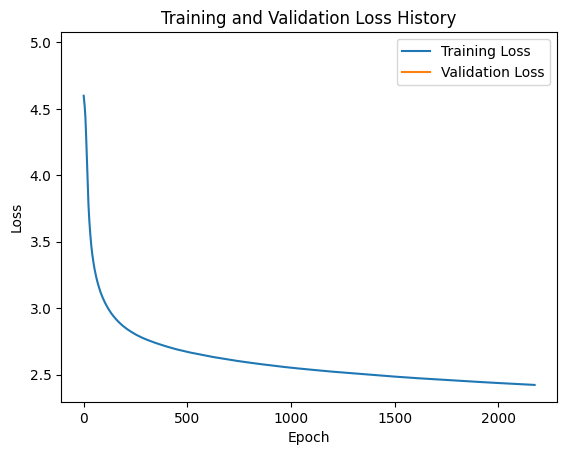

In [17]:
import matplotlib.pyplot as plt

def plot_training_history(train_losses, val_losses):
    """Plots the training and validation loss over epochs."""
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss History")
    plt.legend()
    plt.show()

plot_training_history(train_losses, val_losses)

## Evaluating the model

Below are some visualisations that display the training of three tested models.

# Limitations & Conclusion